# Carregando as bases

In [2]:
import pandas as pd

summary = pd.read_csv('summary.csv')

df_lags =     pd.read_csv('df_lags.csv')
df_lags_mms = pd.read_csv('df_lags_mms.csv')

df_lags_abril =     pd.read_csv('df_lags_abril.csv')
df_lags_mms_abril = pd.read_csv('df_lags_mms_abril.csv')

all_lags_2020 =     pd.read_csv('all_lags_2020.csv')
all_lags_mms_2020 = pd.read_csv('all_lags_mms_2020.csv')

all_lags_2022 =     pd.read_csv('all_lags_2022.csv')
all_lags_mms_2022 = pd.read_csv('all_lags_mms_2022.csv')

all_nasdaq_lags_2022 =     all_lags_2022[['Date','BTC_USD','ETH_USD','XRP_USD','SOL_USD','BNB_USD'] + [col for col in all_lags_2022.columns if 'NASDAQ' in col]]
all_nasdaq_lags_2022.to_csv('all_nasdaq_lags_2022.csv', index=False)

all_nasdaq_lags_mms_2022 = all_lags_mms_2022[['Date','BTC_USD','ETH_USD','XRP_USD','SOL_USD','BNB_USD'] + [col for col in all_lags_mms_2022.columns if 'NASDAQ' in col]]
all_nasdaq_lags_mms_2022.to_csv('all_nasdaq_lags_mms_2022.csv', index=False)

btc_lags =      pd.read_csv('btc_lags.csv')
btc_lags_mms =  pd.read_csv('btc_lags_mms.csv')

eth_lags =      pd.read_csv('eth_lags.csv')
eth_lags_mms =  pd.read_csv('eth_lags_mms.csv')

xrp_lags =      pd.read_csv('xrp_lags.csv')
xrp_lags_mms =  pd.read_csv('xrp_lags_mms.csv')

sol_lags =      pd.read_csv('sol_lags.csv')
sol_lags_mms =  pd.read_csv('sol_lags_mms.csv')

bnb_lags =      pd.read_csv('bnb_lags.csv')
bnb_lags_mms =  pd.read_csv('bnb_lags_mms.csv')

In [125]:
# all_lags_2020      798
# all_lags_mms_2022  132 (lags7, 14, 21, 28) (mms 10, 20, 30)
# len(all_lags_mms_2022.columns)
# all_nasdaq_lags_mms_2022

df_lags['Date'].max()

'2025-03-31'

# Criando funções para calcular vif, stepwise e divisão de treino e teste

In [3]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calcular_vif(X):
    X_const = sm.add_constant(X)
    vif_df = pd.DataFrame()
    vif_df['feature'] = X.columns
    vif_df['VIF'] = [variance_inflation_factor(X_const.values, i+1) for i in range(X.shape[1])]
    return vif_df

# Processo passo a passo
def stepwise_regression(X, y, p_threshold=0.10, vif_threshold=10):
    remaining = list(X.columns)
    selected = []

    while True:
        pvals = pd.Series(index=remaining, dtype=float)
        # Para cada variável restante, ajustar o modelo e obter p-valor
        for feature in remaining:
            current_vars = selected + [feature]
            X_model = sm.add_constant(X[current_vars])
            model = sm.OLS(y, X_model).fit()
            pvals[feature] = model.pvalues[feature]

        # Variável com menor p-valor
        min_pvalue = pvals.min()
        if min_pvalue > p_threshold:
            # Nenhuma variável atende ao critério de p-valor, parar
            break

        to_add = pvals.idxmin()
        candidate_vars = selected + [to_add]
        # Verificar VIF
        vif_df = calcular_vif(X[candidate_vars])
        max_vif = vif_df['VIF'].max()
        if max_vif > vif_threshold:
            # Variável causa multicolinearidade alta, remover a de maior VIF ou parar
            # Aqui, parar ao invés de remover
            break
        else:
            # Adiciona a variável
            selected.append(to_add)
            remaining.remove(to_add)

        if len(remaining) == 0:
            break

    # Modelo final
    X_final = sm.add_constant(X[selected])
    vif_final = calcular_vif(X[selected])
    final_model = sm.OLS(y, X_final).fit()
    return final_model, selected, vif_final

def split_base(base, coluna_corte, data_corte):
  base_temp = base.copy()
  treino = base_temp[base_temp[coluna_corte] < data_corte]
  teste = base_temp[base_temp[coluna_corte] >= data_corte]

  return treino, teste

def run_base(base, y, data_corte):
  df_from_csv = pd.read_csv(base + '.csv')
  base_lr = df_from_csv.copy()

  Ys = ['BTC_USD', 'ETH_USD', 'XRP_USD', 'SOL_USD', 'BNB_USD']

  treino, teste = split_base(base_lr, 'Date', data_corte)

  X_treino = treino.drop(Ys + ['Date'], axis=1, errors='ignore')
  y_treino = pd.Series(treino[y])

  modelo, variaveis_selecionadas, vif_selecionadas = stepwise_regression(X_treino, y_treino)

  X_teste = teste[variaveis_selecionadas]
  previsoes = modelo.predict(sm.add_constant(X_teste))
  result_teste = teste[['Date', y] + variaveis_selecionadas].copy()
  result_teste[y + '_prev'] = previsoes

  return modelo, variaveis_selecionadas, vif_selecionadas, result_teste

## Executar todas as bases e todos os Ys

In [15]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

data_corte = {
    'BTC_USD': '2024-06-01',
    'ETH_USD': '2025-01-01',
    'XRP_USD': '2024-06-01',
    'SOL_USD': '2024-12-01',
    'BNB_USD': '2024-12-01'
}

bases_to_run = pd.DataFrame(
    {
        'base':[
          'all_lags_2020',
          'all_lags_2020',
          'all_lags_2020',
          'all_lags_2020',
          'all_lags_2020',
          'all_lags_mms_2020',
          'all_lags_mms_2020',
          'all_lags_mms_2020',
          'all_lags_mms_2020',
          'all_lags_mms_2020',
          'all_lags_2022',
          'all_lags_2022',
          'all_lags_2022',
          'all_lags_2022',
          'all_lags_2022',
          'all_lags_mms_2022',
          'all_lags_mms_2022',
          'all_lags_mms_2022',
          'all_lags_mms_2022',
          'all_lags_mms_2022',
          'all_nasdaq_lags_2022',
          'all_nasdaq_lags_2022',
          'all_nasdaq_lags_2022',
          'all_nasdaq_lags_2022',
          'all_nasdaq_lags_2022',
          'all_nasdaq_lags_mms_2022',
          'all_nasdaq_lags_mms_2022',
          'all_nasdaq_lags_mms_2022',
          'all_nasdaq_lags_mms_2022',
          'all_nasdaq_lags_mms_2022',
          'btc_lags',
          'btc_lags_mms',
          'eth_lags',
          'eth_lags_mms',
          'xrp_lags',
          'xrp_lags_mms',
          'sol_lags',
          'sol_lags_mms',
          'bnb_lags',
          'bnb_lags_mms'
        ],
        'y':[
          'BTC_USD',
          'ETH_USD',
          'XRP_USD',
          'SOL_USD',
          'BNB_USD',
          'BTC_USD',
          'ETH_USD',
          'XRP_USD',
          'SOL_USD',
          'BNB_USD',
          'BTC_USD',
          'ETH_USD',
          'XRP_USD',
          'SOL_USD',
          'BNB_USD',
          'BTC_USD',
          'ETH_USD',
          'XRP_USD',
          'SOL_USD',
          'BNB_USD',
          'BTC_USD',
          'ETH_USD',
          'XRP_USD',
          'SOL_USD',
          'BNB_USD',
          'BTC_USD',
          'ETH_USD',
          'XRP_USD',
          'SOL_USD',
          'BNB_USD',
          'BTC_USD',
          'BTC_USD',
          'ETH_USD',
          'ETH_USD',
          'XRP_USD',
          'XRP_USD',
          'SOL_USD',
          'SOL_USD',
          'BNB_USD',
          'BNB_USD'
        ]
    }
)

all_results = pd.DataFrame()

for index, row in bases_to_run.iterrows():
  base = row['base']
  y = row['y']
  modelo, variaveis_selecionadas, vif_selecionadas, resultado_teste = run_base(base, y, data_corte[y])

  Y_teste = resultado_teste[y]
  previsoes = resultado_teste[y + '_prev']

  resultado_teste
  residuos = previsoes - Y_teste

  erro_medio = residuos.mean()
  r2 = r2_score(Y_teste, previsoes)
  rmse = np.sqrt(mean_squared_error(Y_teste, previsoes))

  media_Y_teste = Y_teste.mean()
  rmse_percentual = (rmse / media_Y_teste) * 100

  resultado_teste.to_csv('prev_' + base + '(' + y + ').csv', index=False)

  nova_linha = pd.DataFrame({
      'Y':[y],
      'base':[base],
      'X_selecionados':[variaveis_selecionadas],
      'treino_R2':[modelo.rsquared],
      'treino_R2Adj':[modelo.rsquared_adj],
      'treino_AIC':[modelo.aic],
      'treino_BIC':[modelo.bic],
      'teste_Error':erro_medio,
      'teste_R2':r2,
      'teste_RMSE':rmse,
      'teste_RMSE%':rmse_percentual,
      'teste_data_corte':data_corte[y]
      })
  all_results = pd.concat([all_results, nova_linha], ignore_index=True)

  parametros = modelo.params
  formula = f"{y}_prev = {parametros['const']:.2f}"
  for col in variaveis_selecionadas:
    formula += f" + ({parametros[col]:.2f}) * {col}"

  print()
  print('Base:', base)
  print('Y:', y)
  print('Variáveis selecionadas:', variaveis_selecionadas)
  print()
  print('                                   VIFs')
  print('==============================================================================')
  print(vif_selecionadas)
  print('==============================================================================')
  print()
  print(modelo.summary())
  print()
  print('                                  Fórmula')
  print('==============================================================================')
  print(formula)
  print('==============================================================================')
  print()
  print('                              RESULTADO TESTE')
  print('==============================================================================')
  print('Data de corte para treino e teste:', data_corte[y])
  print('Erro médio:', erro_medio)
  print('R2:', r2)
  print('RMSE:', rmse)
  print('RMSE%:', rmse_percentual)
  print('==============================================================================')
  print()


Base: all_lags_2020
Y: BTC_USD
Variáveis selecionadas: ['NASDAQ_EUA_lag_7', 'BRL_USD_lag_7', 'Nikkei_Japao_lag_50', 'CNY_USD_lag_50', 'Shanghai_SSE_China_lag_50', 'GBP_USD_lag_7', 'Shenzhen_China_lag_7']

                                   VIFs
                     feature       VIF
0           NASDAQ_EUA_lag_7  6.216075
1              BRL_USD_lag_7  1.711944
2        Nikkei_Japao_lag_50  5.786724
3             CNY_USD_lag_50  3.493371
4  Shanghai_SSE_China_lag_50  4.032596
5              GBP_USD_lag_7  3.625432
6       Shenzhen_China_lag_7  6.510172

                            OLS Regression Results                            
Dep. Variable:                BTC_USD   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     1602.
Date:                Sat, 10 May 2025   Prob (F-statistic):               0.00
Time:                        20:00:59   Log-Li

In [17]:
import numpy as np

r = all_results.copy()

r['Order'] = -1
r.loc[r['Y'] == 'BTC_USD', 'Order'] = 1
r.loc[r['Y'] == 'ETH_USD', 'Order'] = 2
r.loc[r['Y'] == 'XRP_USD', 'Order'] = 3
r.loc[r['Y'] == 'SOL_USD', 'Order'] = 4
r.loc[r['Y'] == 'BNB_USD', 'Order'] = 5

r.sort_values(by='Order', inplace=True)
r.sort_values(by=['Order', 'teste_R2'], ascending=[True, False], inplace=True)

r.to_csv('results.csv', index=False)

In [86]:
r

,Y,base,X_selecionados,treino_R2,treino_R2Adj,treino_AIC,treino_BIC,teste_Error,teste_R2,teste_RMSE,teste_RMSE%,Order
15,BTC_USD,all_lags_mms_2022,"[NASDAQ_EUA_lag_7, NYSE_EUA_MM_30, GBP_USD_MM_30]",0.912749,0.912462,18468.470449,18487.741771,-7475.030714,-1.032650,9889.298572,10.450444,1
10,BTC_USD,all_lags_2022,"[NASDAQ_EUA_lag_7, NYSE_EUA_lag_50, GBP_USD_la...",0.920179,0.919827,18389.128942,18413.218095,-9072.844446,-1.999018,12012.234358,12.693841,1
0,BTC_USD,all_lags_2020,"[NASDAQ_EUA_lag_7, CNY_USD_lag_50, Nikkei_Japa...",0.867112,0.866798,34827.061988,34854.242127,-16879.000559,-5.367539,17503.304205,18.496488,1
20,BTC_USD,btc_lags,"[NASDAQ_EUA_lag_7, BRL_USD_lag_50]",0.898884,0.898814,59132.071532,59149.979606,-20439.416868,-8.212810,21053.790448,22.248439,1
5,BTC_USD,all_lags_mms_2020,"[NASDAQ_EUA_lag_7, CNY_USD_lag_28, Nikkei_Japa...",0.850157,0.849892,35028.722353,35050.466465,-22974.254449,-10.525666,23548.717435,24.884934,1
21,BTC_USD,btc_lags_mms,"[NASDAQ_EUA_lag_7, BRL_USD_lag_28, LondonStock...",0.905010,0.904878,58955.406975,58985.253763,-23089.430320,-10.646634,23671.973129,25.015184,1
6,ETH_USD,all_lags_mms_2020,"[NASDAQ_EUA_lag_7, LondonStock_ReinoUnido_MM_3...",0.855314,0.854800,25243.993775,25282.045970,7.872235,0.549322,443.096477,15.173759,2
1,ETH_USD,all_lags_2020,"[NASDAQ_EUA_lag_7, LondonStock_ReinoUnido_lag_...",0.869155,0.868613,25075.451623,25118.939846,13.222949,0.381018,519.282664,17.782741,2
23,ETH_USD,eth_lags_mms,"[NASDAQ_EUA_lag_7, LondonStock_ReinoUnido_lag_...",0.898305,0.898107,38050.703273,38085.834215,672.671680,-0.609875,837.454162,28.678467,2
22,ETH_USD,eth_lags,"[NASDAQ_EUA_lag_7, LondonStock_ReinoUnido_lag_...",0.900147,0.899953,38003.567362,38038.698304,674.923599,-0.731967,868.629776,29.746070,2


In [18]:
indices_max = r.groupby('Y')['teste_R2'].idxmax()
best = r.loc[indices_max]
best.sort_values(by='Order', inplace=True)

best.to_csv('results_best.csv', index=False)

best

,Y,base,X_selecionados,treino_R2,treino_R2Adj,treino_AIC,treino_BIC,teste_Error,teste_R2,teste_RMSE,teste_RMSE%,teste_data_corte,Order
20,BTC_USD,all_nasdaq_lags_2022,"[NASDAQ_EUA_lag_7, NASDAQ_EUA_lag_50]",0.836470,0.836021,14841.057049,14854.840289,-1911.237111,0.583460,10621.875019,13.640491,2024-06-01,1
1,ETH_USD,all_lags_2020,"[NASDAQ_EUA_lag_7, LondonStock_ReinoUnido_lag_...",0.857680,0.857183,25712.359778,25750.538766,138.605025,0.600228,359.174157,13.446527,2025-01-01,2
22,XRP_USD,all_nasdaq_lags_2022,"[NASDAQ_EUA_lag_7, NASDAQ_EUA_lag_50]",0.474643,0.473199,-1693.453821,-1679.670581,-0.660051,-0.405841,1.139165,83.478301,2024-06-01,3
28,SOL_USD,all_nasdaq_lags_mms_2022,[NASDAQ_EUA_lag_7],0.811977,0.811770,8649.176932,8658.812593,5.068561,0.299172,33.209081,17.739092,2024-12-01,4
38,BNB_USD,bnb_lags,"[NASDAQ_EUA_lag_7, NYSE_EUA_lag_50, LondonStoc...",0.880780,0.880641,29330.132012,29353.552640,-2.137395,0.532911,33.819916,5.138577,2024-12-01,5


# Gráfico das previsões

In [6]:
results = pd.read_csv('results.csv')
results.head()

,Y,base,X_selecionados,treino_R2,treino_R2Adj,treino_AIC,treino_BIC,teste_Error,teste_R2,teste_RMSE,teste_RMSE%,teste_data_corte,Order
0,BTC_USD,all_nasdaq_lags_2022,"['NASDAQ_EUA_lag_7', 'NASDAQ_EUA_lag_50']",0.836470,0.836021,14841.057049,14854.840289,-1911.237111,0.583460,10621.875019,13.640491,2024-06-01,1
1,BTC_USD,all_nasdaq_lags_mms_2022,['NASDAQ_EUA_MM_10'],0.815430,0.815177,14927.532000,14936.720827,-3746.994582,0.517036,11437.475319,14.687876,2024-06-01,1
2,BTC_USD,all_lags_mms_2020,"['NASDAQ_EUA_lag_7', 'BRL_USD_lag_7', 'NYSE_EU...",0.857497,0.856929,30743.404173,30780.657121,8097.365971,0.213726,14593.507282,18.740816,2024-06-01,1
3,BTC_USD,all_lags_2020,"['NASDAQ_EUA_lag_7', 'BRL_USD_lag_7', 'Nikkei_...",0.881699,0.881149,30463.783766,30506.358564,1487.584200,-0.011508,16552.260535,21.256225,2024-06-01,1
4,BTC_USD,btc_lags_mms,"['NASDAQ_EUA_lag_7', 'LondonStock_ReinoUnido_l...",0.898890,0.898741,54634.423974,54663.943802,-10465.601619,-0.077314,17082.200228,21.936768,2024-06-01,1


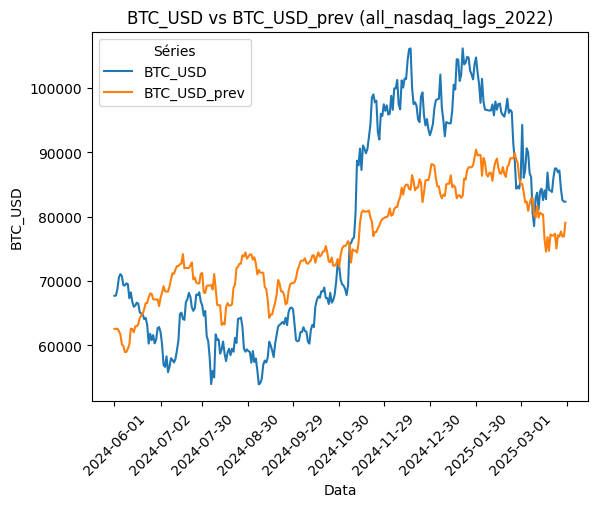

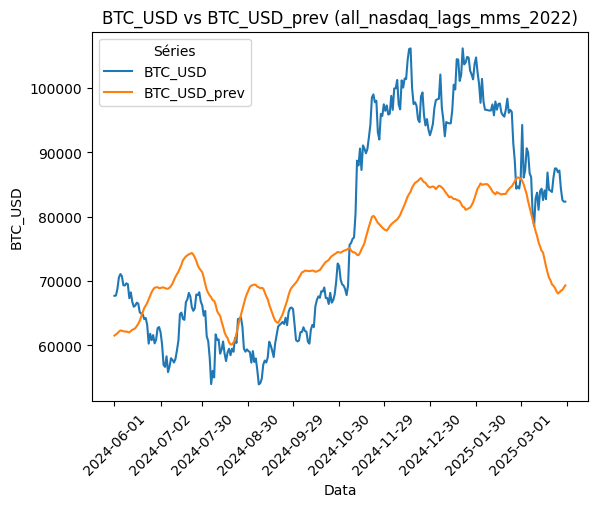

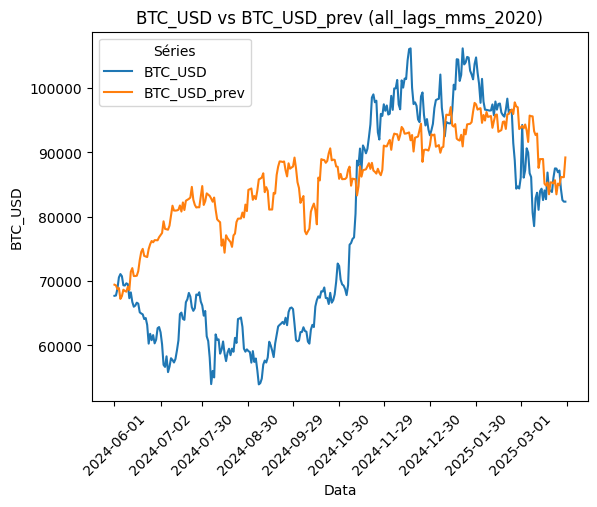

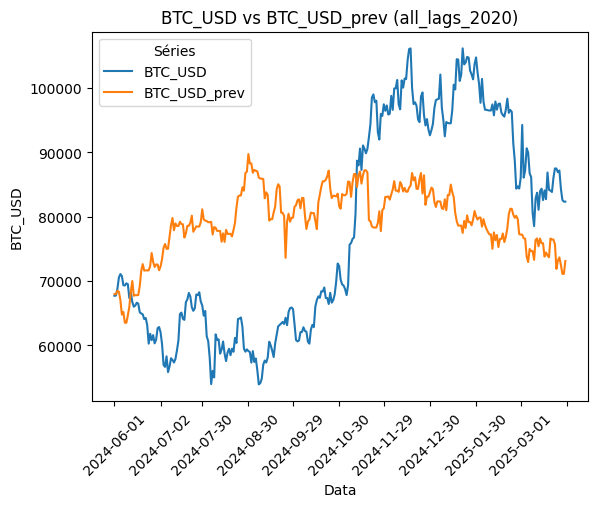

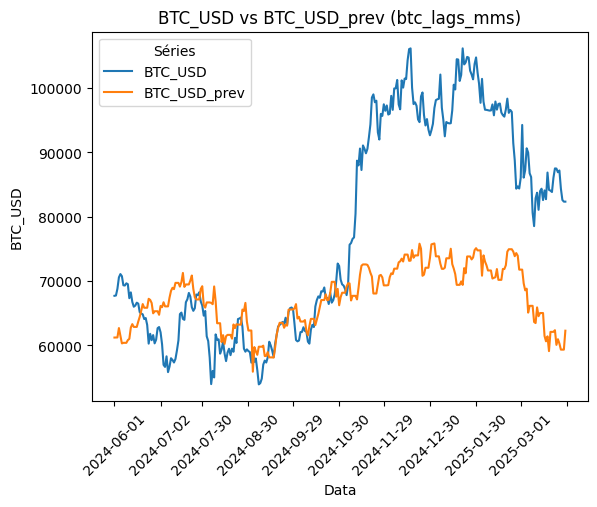

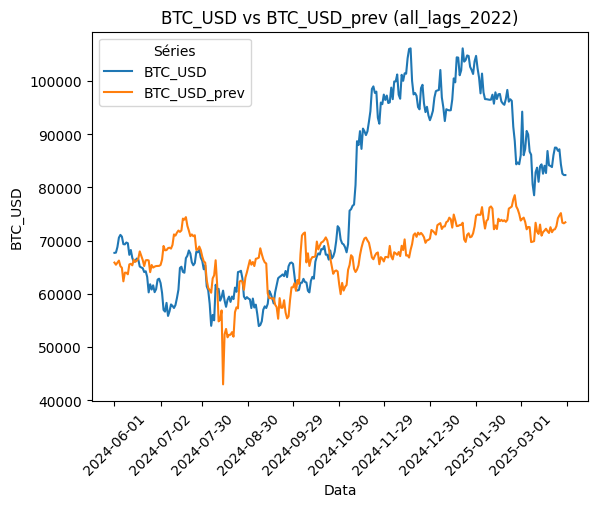

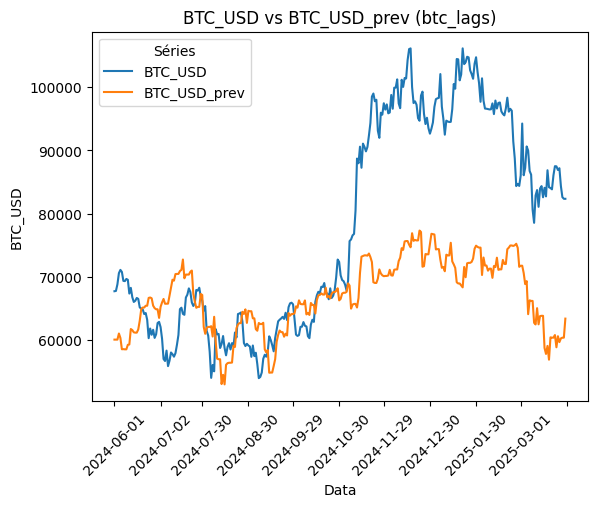

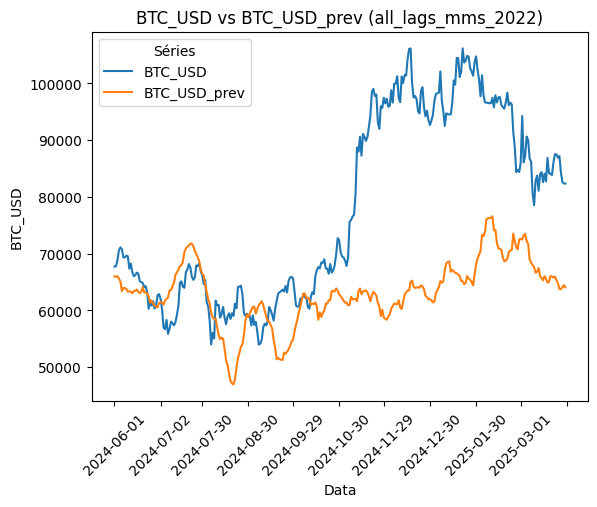

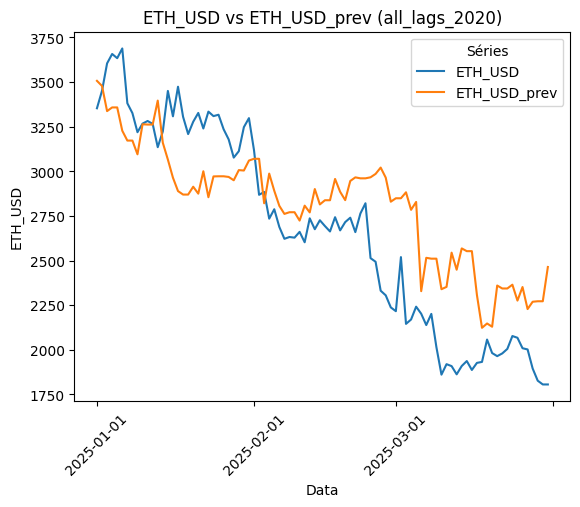

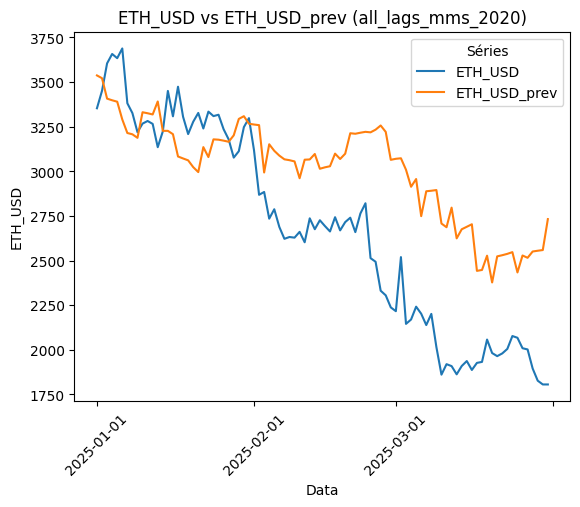

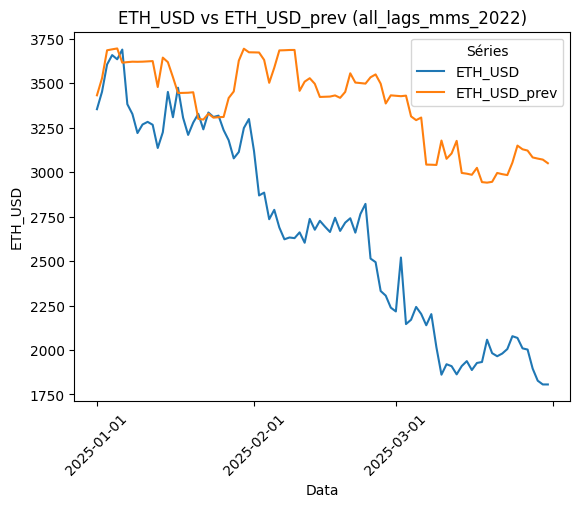

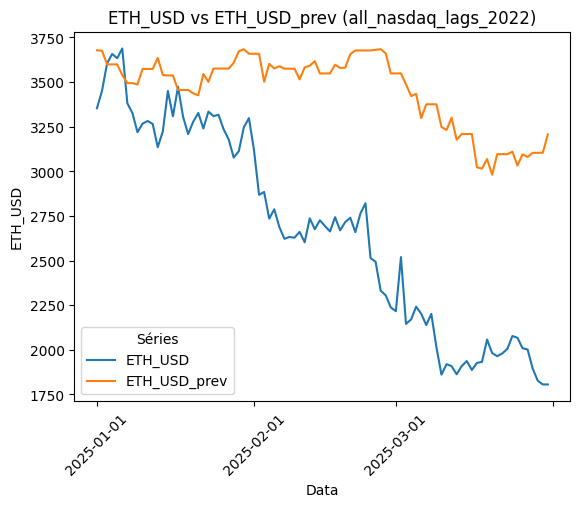

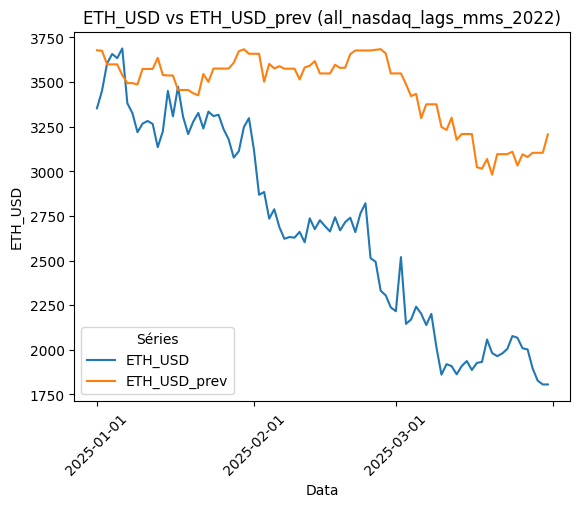

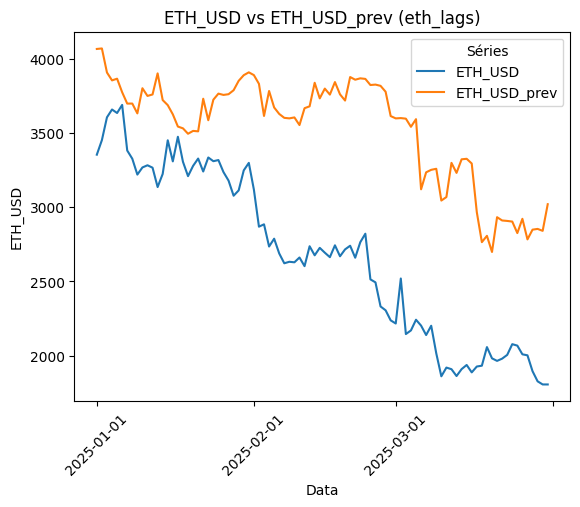

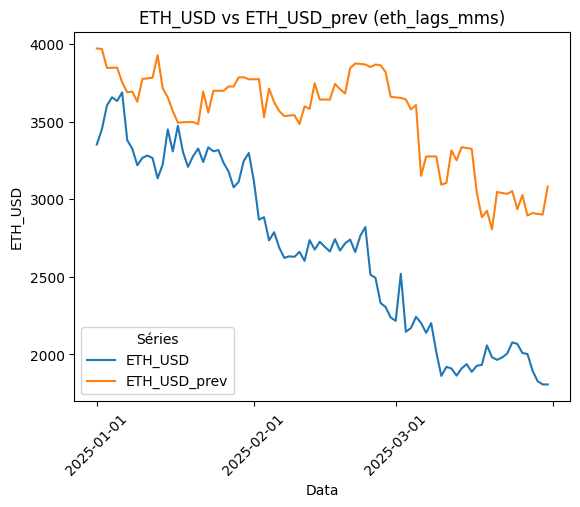

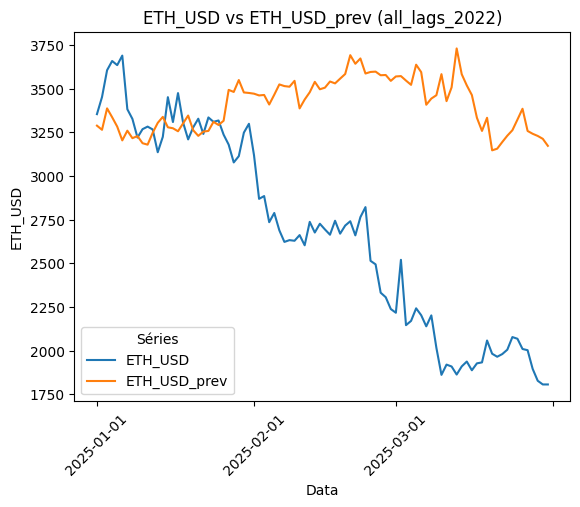

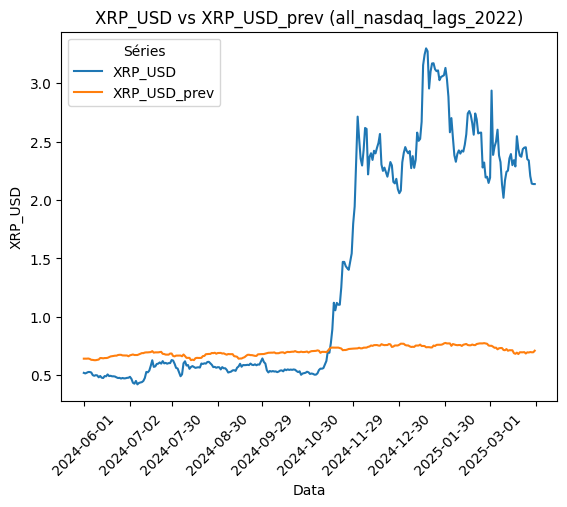

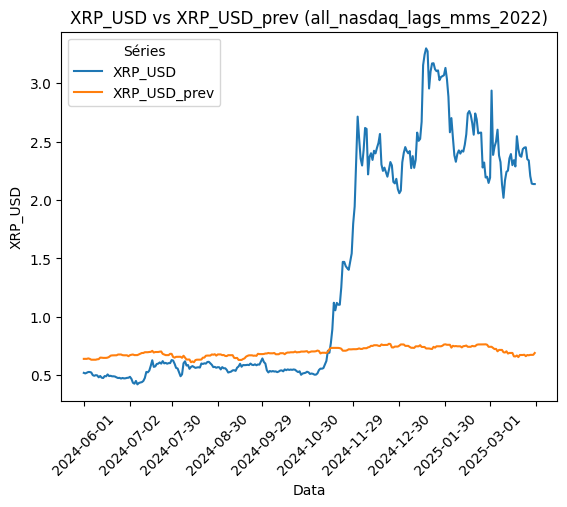

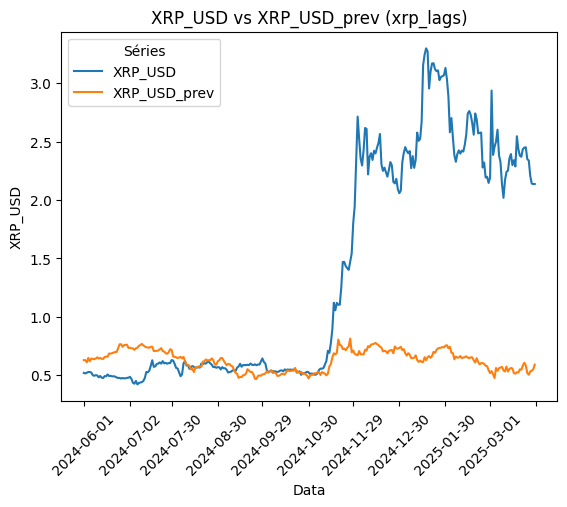

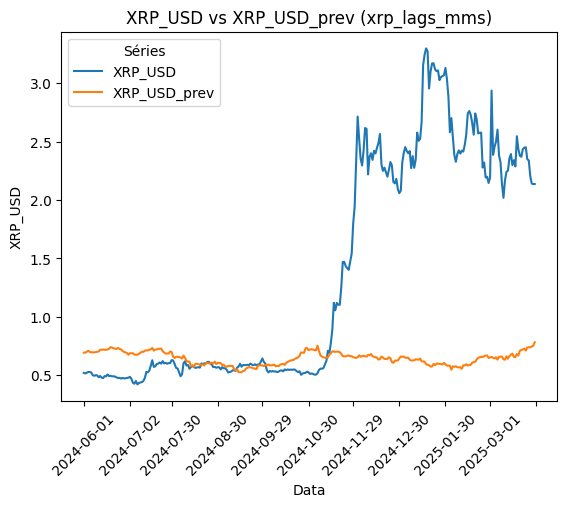

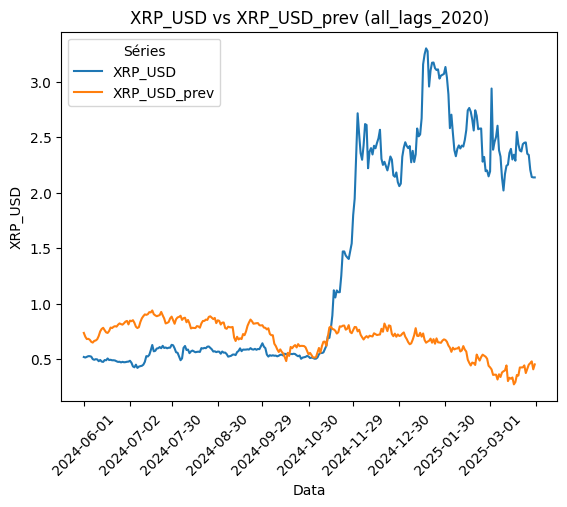

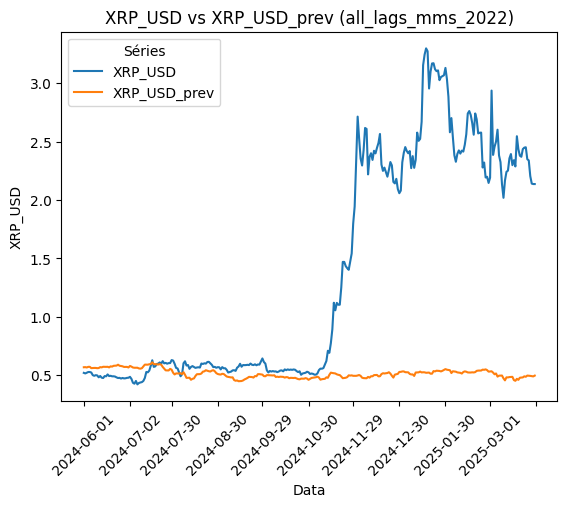

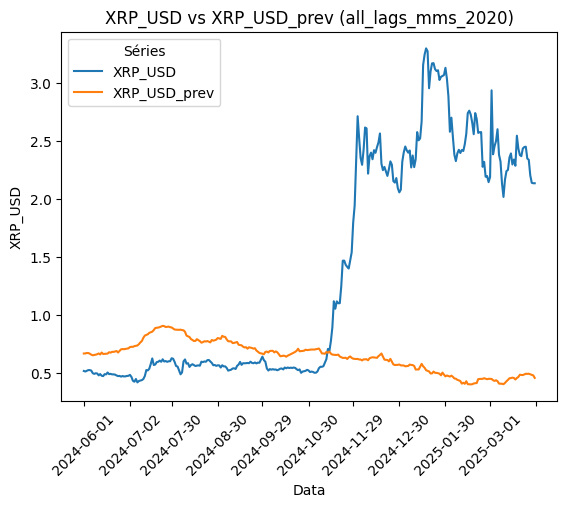

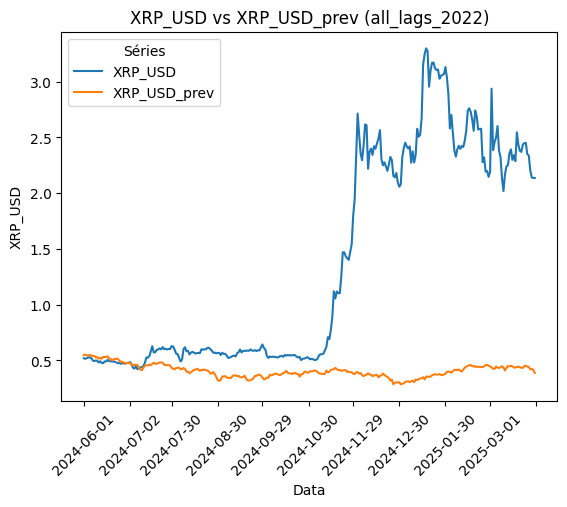

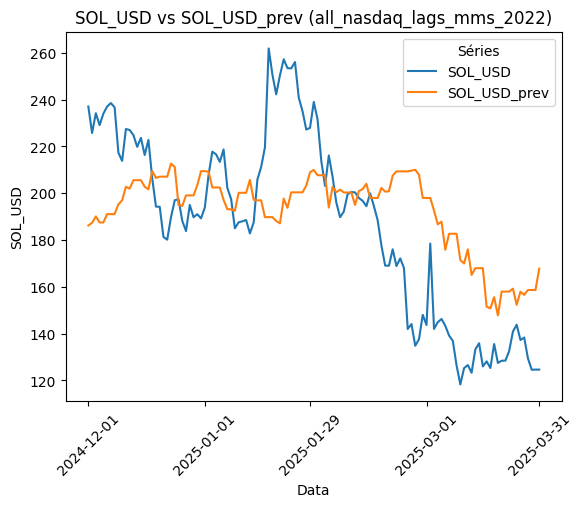

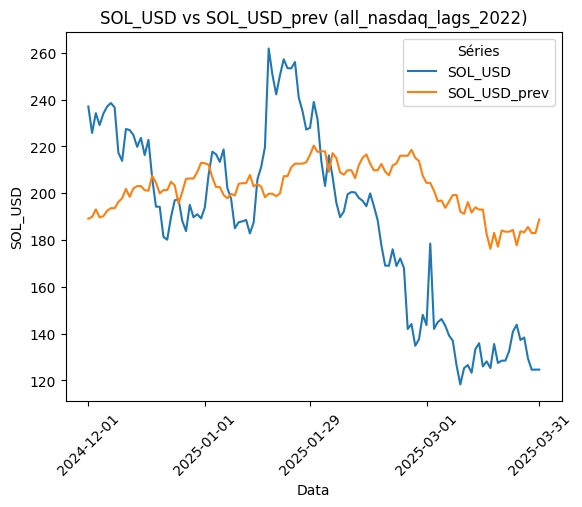

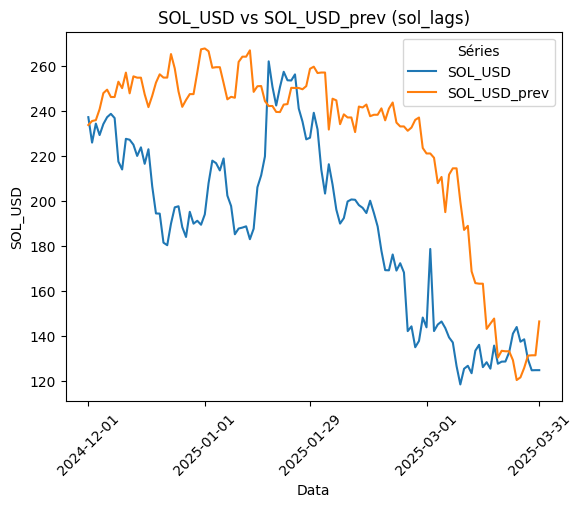

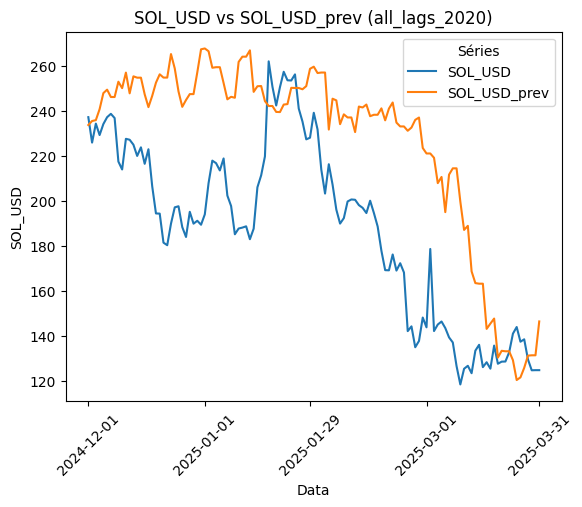

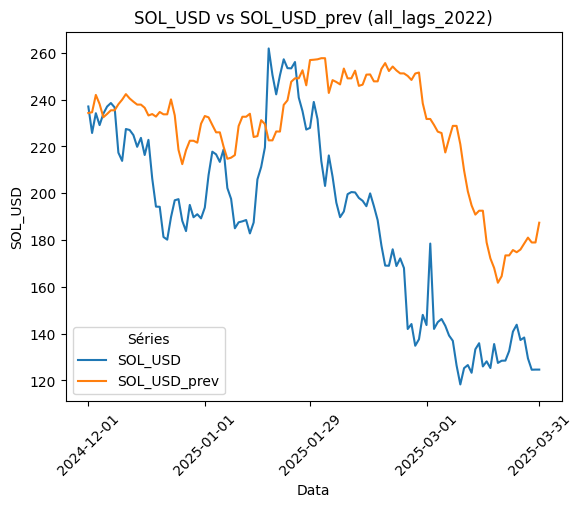

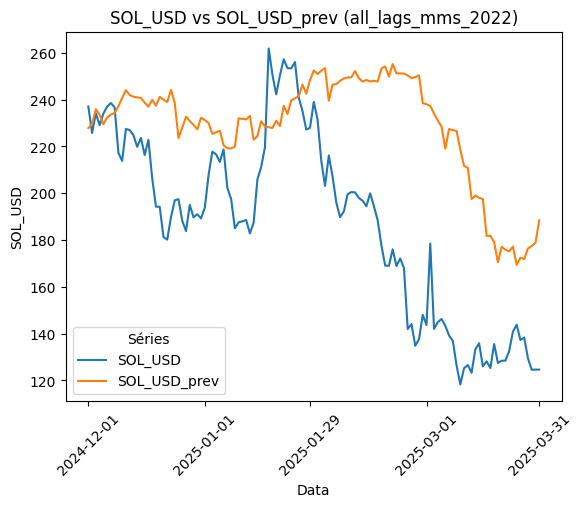

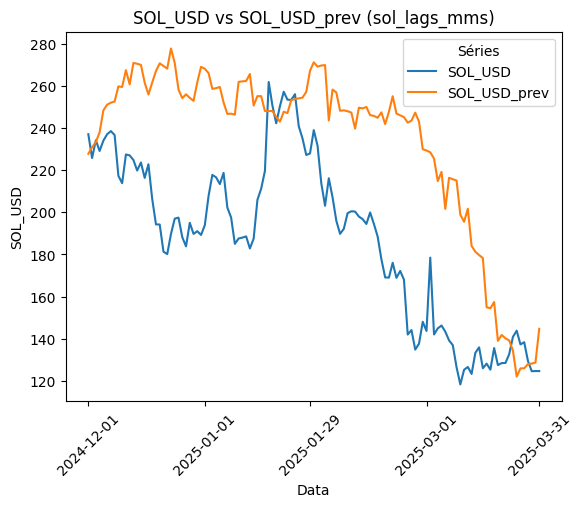

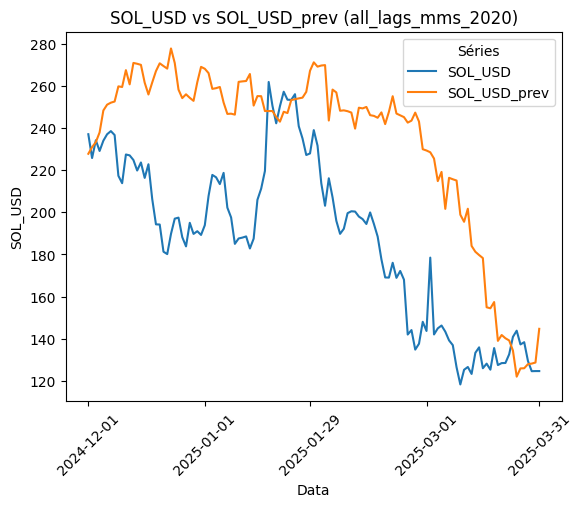

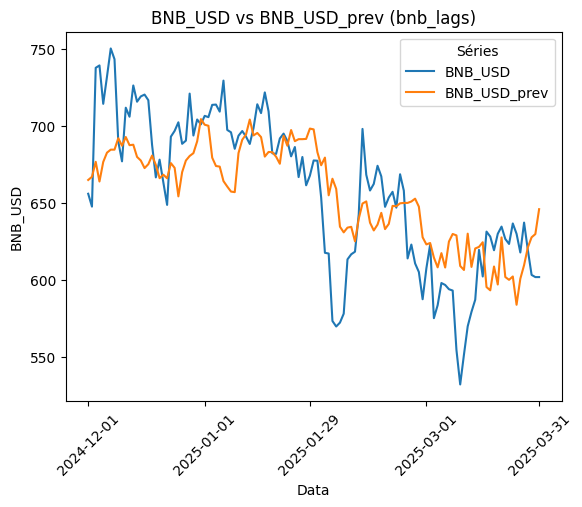

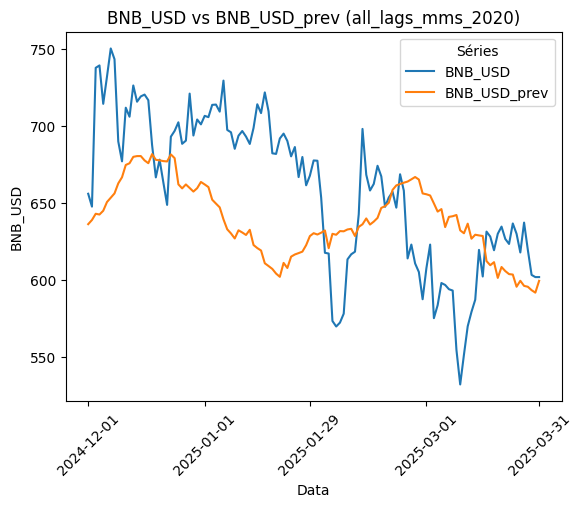

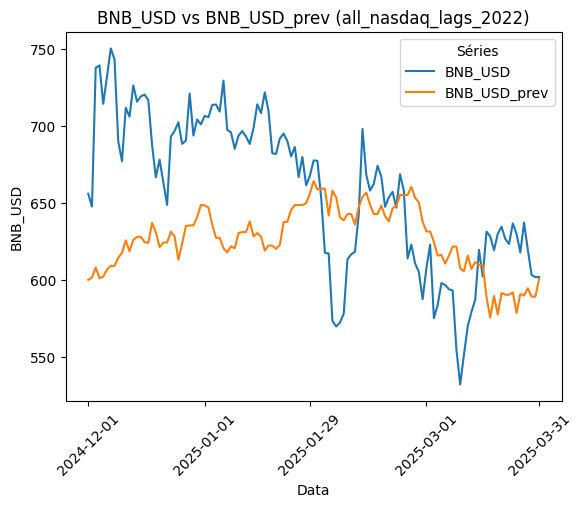

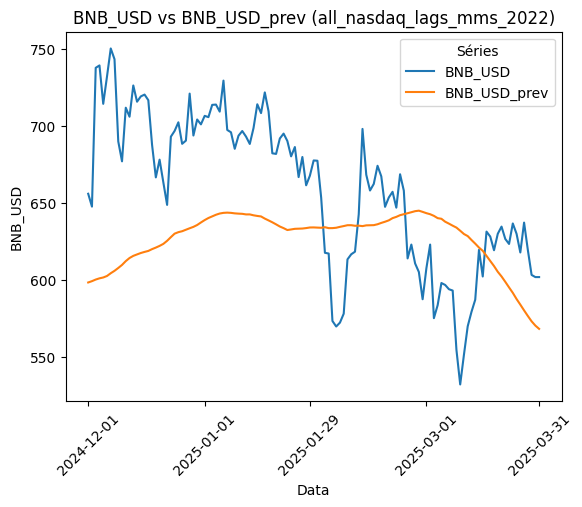

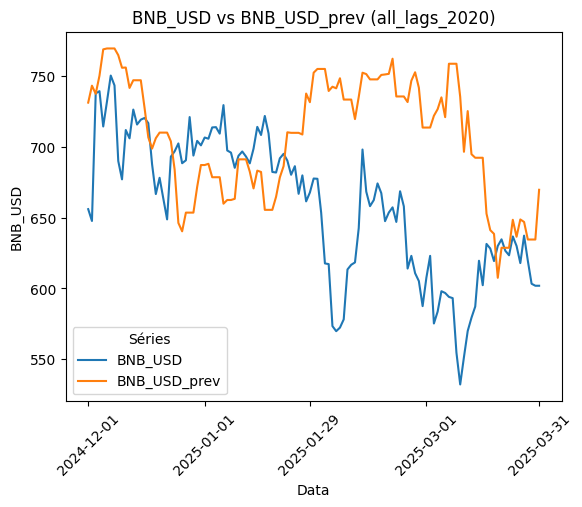

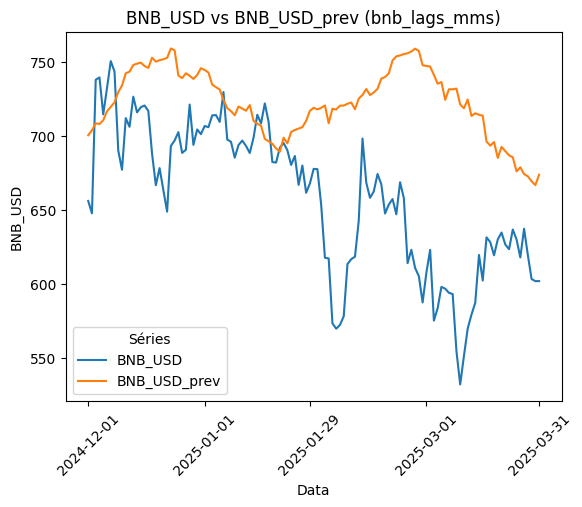

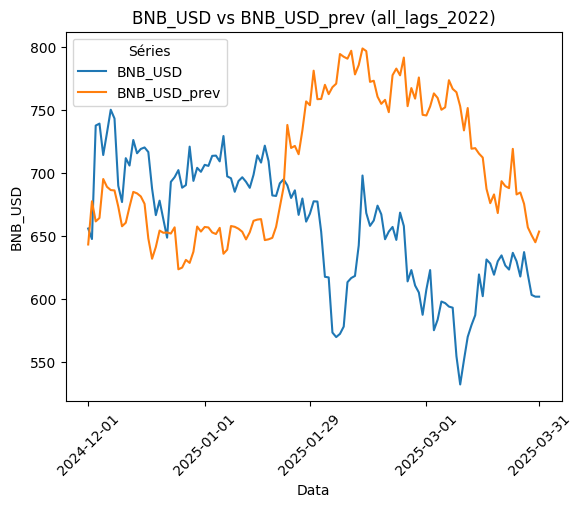

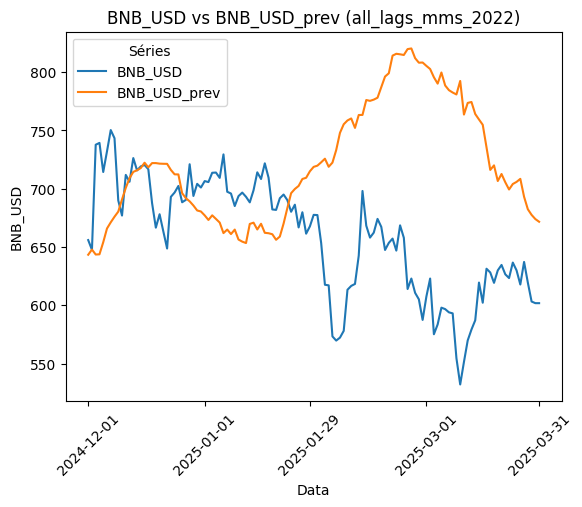

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def save_graph_image(base, base_name, file_name):
  Y = base.columns[1]
  Y_previsto = base.columns[-1]

  # Transformando o DataFrame pra formato longo
  df_long = base.reset_index().melt(id_vars='Date', value_vars=[Y, Y_previsto],
                                  var_name='Séries', value_name='Valor')

  sns.lineplot(x='Date', y='Valor', hue='Séries', data=df_long)
  plt.xlabel('Data')
  plt.ylabel(Y)
  plt.title(Y + ' vs ' + Y_previsto + ' (' + base_name + ')')

  ax = plt.gca()  # obtém o eixo atual
  ax.xaxis.set_major_locator(mdates.MonthLocator())  # intervalo de meses
  # ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # formato mês/ano

  plt.xticks(rotation=45)  # rotaciona as datas para melhor visualização
  # plt.tight_layout()  # ajusta o layout para não cortar o texto
  plt.savefig(file_name)
  plt.show()

for index, row in results.iterrows():
  nome_arquivo_previsao = 'prev_' + row['base'] + '(' + row['Y'] + ')'

  base = pd.read_csv(nome_arquivo_previsao +'.csv')
  save_graph_image(base, row['base'], 'img_' + nome_arquivo_previsao + '.png')

In [25]:
prev_base = pd.read_csv('prev_all_lags_mms_2022(BTC_USD).csv')

In [94]:
prev_base

,BTC_USD,NASDAQ_EUA_lag_7,NYSE_EUA_MM_30,GBP_USD_MM_30,BTC_USD_prev
0,97279.789062,19003.650391,19682.244076,1.283236,82731.034804
1,95865.304688,19054.839844,19707.713737,1.281971,83294.458738
2,96002.164062,19174.300781,19733.153060,1.280504,84239.777127
3,98768.531250,19060.480469,19755.158073,1.279222,83909.649272
4,96593.570312,19060.480469,19780.262435,1.278232,84171.596817
...,...,...,...,...,...
116,87177.101562,17691.630859,19628.039974,1.279364,75841.634503
117,84353.148438,17784.050781,19602.243359,1.280505,76048.815742
118,82597.585938,17784.050781,19579.058398,1.281784,75769.347958
119,82334.523438,17784.050781,19564.817448,1.282776,75576.485484


NameError: name 'prev_base' is not defined

In [92]:
df_long

,index,Série,Valor
0,0,BTC_USD_prev,82731.034804
1,1,BTC_USD_prev,83294.458738
2,2,BTC_USD_prev,84239.777127
3,3,BTC_USD_prev,83909.649272
4,4,BTC_USD_prev,84171.596817
...,...,...,...
237,116,BTC_USD,87177.101562
238,117,BTC_USD,84353.148438
239,118,BTC_USD,82597.585938
240,119,BTC_USD,82334.523438
